In [1]:
import json
import time
import joblib
import numpy as np
import pandas as pd
import shap
import os
import glob
from matplotlib import pyplot as plt
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


/Users/admin/miniforge3/envs/shap311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MODEL_PATH = "threat_score_model.joblib"
DATA_PATH   = "Processed_UE_Datasets_unscaled"
OUT_PATH   = "global_explanations.json"
label_column = "binary_label" 
# -----------------------------
# Sample for SHAP (important)
# -----------------------------
RANDOM_STATE = 42
BACKGROUND_ROWS = 1000
EXPLAIN_ROWS = 10000
MAX_EVALS       = 2000  # used only for permutation fallback


In [3]:
def load_model(model_path):
    bundle = joblib.load(model_path)
    model = bundle["model"]
    feature_columns = bundle["feature_columns"]
    return model, feature_columns

def ensure_numeric(df, feature_columns):
    X = df[feature_columns].copy()
    for c in feature_columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    return X

def compute_global_shap(model, X_background, X_explain, max_evals=2000):

    # Try TreeExplainer first (fastest)
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_explain)

        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # class 1

        method = "TreeExplainer"
        return np.array(shap_values), method

    except Exception:
        pass

    # Fallback: permutation-based SHAP
    def f(x):
        x = pd.DataFrame(x, columns=X_explain.columns)
        return model.predict_proba(x)[:, 1]

    explainer = shap.Explainer(f, X_background, algorithm="permutation")
    exp = explainer(X_explain, max_evals=max_evals)

    method = "PermutationExplainer"
    return np.array(exp.values), method


In [4]:
print("Loading model...")
model, feature_columns = load_model(MODEL_PATH)

print("Num features:", len(feature_columns))
feature_columns[:len(feature_columns)]


Loading model...
Num features: 14


['epre',
 'pusch_snr',
 'p_ue',
 'ul_mcs',
 'cqi',
 'ul_bitrate',
 'dl_mcs',
 'dl_retx',
 'ul_tx',
 'dl_tx',
 'ul_retx',
 'dl_bitrate',
 'dl_err',
 'ul_err']

In [5]:
print("Loading data...")
csv_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))
train_files = [f for f in csv_files if "test" not in os.path.basename(f).lower()]

if not train_files:
    raise RuntimeError("No training files found (no CSVs without 'test' in filename).")

dfs = []
for f in train_files:
    df = pd.read_csv(f)
    missing = [c for c in feature_columns + [label_column] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in file: {os.path.basename(f)}")
    dfs.append(df)

data = pd.concat(dfs, axis=0).reset_index(drop=True)

X = data[feature_columns].copy()
y = data[label_column].copy()

# Ensure numeric
for c in feature_columns:
    X[c] = pd.to_numeric(X[c], errors="coerce")
y = pd.to_numeric(y, errors="coerce").fillna(0).astype(int)


Loading data...


In [6]:
n = len(X)
rng = np.random.default_rng(RANDOM_STATE)

bg_idx = rng.choice(n, size=min(BACKGROUND_ROWS, n), replace=False)
ex_idx = rng.choice(n, size=min(EXPLAIN_ROWS, n), replace=False)

X_background = X.iloc[bg_idx]
# Save background for the API (used to initialize SHAP explainer once)
X_background.to_parquet("shap_background.parquet", index=False)
print("Saved shap_background.parquet with", len(X_background), "rows")

X_explain = X.iloc[ex_idx]

print("Background rows:", len(X_background))
print("Explain rows:", len(X_explain))


Saved shap_background.parquet with 2000 rows
Background rows: 2000
Explain rows: 10000


In [7]:
print("Computing SHAP values (global)...")
shap_vals, shap_method = compute_global_shap(
    model=model,
    X_background=X_background,
    X_explain=X_explain,
    max_evals=MAX_EVALS
)

print("SHAP method:", shap_method)
print("SHAP shape:", shap_vals.shape)  # (rows, features)


Computing SHAP values (global)...
SHAP method: TreeExplainer
SHAP shape: (10000, 14)


In [ ]:
mean_shap = shap_vals.mean(axis=0)
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

global_features = []
for i, feat in enumerate(feature_columns):
    ms = float(mean_shap[i])
    mas = float(mean_abs_shap[i])

    direction = (
        "toward_attack" if ms > 0
        else "toward_normal" if ms < 0
        else "neutral"
    )

    global_features.append({
        "feature": feat,
        "mean_shap": ms,
        "mean_abs_shap": mas,
        "direction": direction
    })

global_features.sort(key=lambda x: x["mean_abs_shap"], reverse=True)

pd.DataFrame(global_features).head(20)

,feature,mean_shap,mean_abs_shap,direction
0,dl_bitrate,-0.022206,0.461256,toward_normal
1,dl_tx,-0.153572,0.415160,toward_normal
2,ul_tx,0.056865,0.336464,toward_attack
3,ul_bitrate,0.020550,0.240944,toward_attack
4,epre,0.035484,0.229886,toward_attack
5,ul_retx,0.065570,0.196847,toward_attack
6,ul_mcs,-0.047484,0.142422,toward_normal
7,p_ue,0.035309,0.111014,toward_attack
8,dl_retx,0.052866,0.086711,toward_attack
9,dl_mcs,-0.030517,0.056470,toward_normal


In [ ]:
out = {
    "status": "computed",
    "computed_at_unix": int(time.time()),
    "method": shap_method,
    "feature_columns": feature_columns,
    "background_rows": len(X_background),
    "model_output": "threat_score",
    "global_feature_effects": global_features,
}

with open(OUT_PATH, "w") as f:
    json.dump(out, f, indent=2)

print(f"✅ Global SHAP saved to {OUT_PATH}")
print(f"Method used: {shap_method}")


✅ Global SHAP saved to global_explanations.json
Method used: TreeExplainer


Text(0.5, 0, 'mean(|SHAP|)')

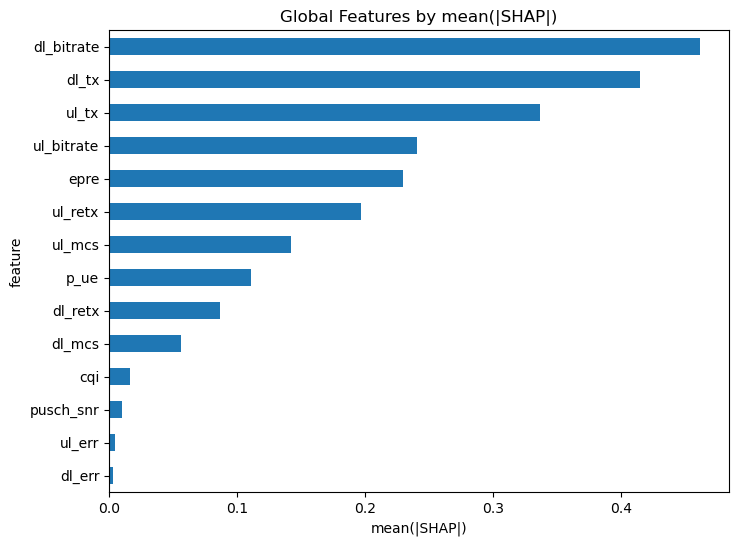

In [ ]:
top = pd.DataFrame(global_features).iloc[::-1]  # reverse for horizontal plot
ax = top.plot(kind="barh", x="feature", y="mean_abs_shap", legend=False, figsize=(8,6))
ax.set_title("Global Features by mean(|SHAP|)")
ax.set_xlabel("mean(|SHAP|)")
